# Citation Hallucination Detection — Zero-Shot Pipeline
Runs the full pipeline: generate → verify → score → visualize

In [ ]:
!pip install -q torch transformers accelerate requests tqdm
import torch
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'NONE — switch runtime!'}")
print(f"VRAM: {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB" if torch.cuda.is_available() else '')

In [ ]:
from huggingface_hub import login
login(token="")

In [ ]:
MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
MAX_PROMPTS = 5
MAX_NEW_TOKENS = 1024
TEMPERATURE = 0.7

## Prompts (from data/prompts/scientific.json)

In [ ]:
PROMPTS = [
    {"id": "sci_001", "domain": "scientific", "prompt": "Write a 500-word essay explaining the Transformer architecture and its impact on natural language processing. Include at least 3 citations to foundational papers with author names and publication years."},
    {"id": "sci_002", "domain": "scientific", "prompt": "Discuss the development and applications of CRISPR-Cas9 gene editing technology. Cite at least 3 seminal papers that contributed to this field."},
    {"id": "sci_003", "domain": "scientific", "prompt": "Explain how deep reinforcement learning achieved superhuman performance in games like Go and Chess. Reference the key papers with proper citations."},
    {"id": "sci_004", "domain": "scientific", "prompt": "Describe the methodology and significance of the AlphaFold protein structure prediction system. Include citations to the original research papers."},
    {"id": "sci_005", "domain": "scientific", "prompt": "Write about the discovery and implications of the Higgs boson. Cite the foundational theoretical papers and experimental confirmation studies."},
]
print(f"{len(PROMPTS)} prompts")

5 prompts


## Citation Extraction

In [ ]:
import re
from dataclasses import dataclass, asdict
from typing import List, Optional

@dataclass
class Citation:
    raw_text: str
    start_pos: int
    end_pos: int
    extracted_authors: Optional[List[str]] = None
    extracted_year: Optional[int] = None
    extracted_title: Optional[str] = None
    citation_type: str = "academic"

# Citation regex patterns
CITATION_PATTERNS = [
    # (Author et al., 2020) or (Author & Other, 2020)
    re.compile(r'\(([A-Z][a-z]+(?:\s+(?:et\s+al\.?|&|and)\s+[A-Z][a-z]+)*,?\s*\d{4}[a-z]?)\)'),
    # Author et al. (2020)
    re.compile(r'([A-Z][a-z]+(?:\s+et\s+al\.?))\s*\((\d{4}[a-z]?)\)'),
    # Author (Year) or Author and Author (Year)
    re.compile(r'([A-Z][a-z]+(?:\s+(?:and|&)\s+[A-Z][a-z]+)?)\s*\((\d{4})\)'),
    # "Title" (Year)
    re.compile(r'"([^"]{10,100})"\s*\((\d{4})\)'),
    # Author, Year pattern
    re.compile(r'([A-Z][a-z]+(?:\s+et\s+al\.?)?),?\s+(\d{4})'),
]

def extract_citations(text):
    citations = []
    seen = set()
    for pat in CITATION_PATTERNS:
        for m in pat.finditer(text):
            s, e = m.span()
            if any(s <= p <= e for p in seen):
                continue
            seen.update(range(s, e+1))
            c = Citation(raw_text=m.group(0), start_pos=s, end_pos=e)
            yr = re.search(r'\d{4}', m.group(0))
            if yr:
                c.extracted_year = int(yr.group())
            au = re.search(r'([A-Z][a-z]+)', m.group(0))
            if au:
                c.extracted_authors = [au.group(1)]
            citations.append(c)
    return citations

# Quick test
test = extract_citations("Vaswani et al. (2017) introduced the Transformer. See also (Devlin et al., 2019).")
print(f"Test extraction: {len(test)} citations found")
for c in test:
    print(f"  {c.raw_text} — authors={c.extracted_authors}, year={c.extracted_year}")

Test extraction: 2 citations found
  Vaswani et al. (2017) — authors=['Vaswani'], year=2017
  Devlin et al., 2019 — authors=['Devlin'], year=2019


## Essay Generation

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from datetime import datetime
import json

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, device_map="auto",
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print(f"Model loaded. {model.config.num_hidden_layers} layers, {model.config.num_attention_heads} heads")

Loading meta-llama/Llama-3.2-3B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Model loaded. 28 layers, 24 heads


In [ ]:
SYSTEM_PROMPT = """You are an academic expert writing for a peer-reviewed journal.
You MUST include proper academic citations in the format: Author (Year) or (Author et al., Year).
Every factual claim must be supported by a citation. Use real author names and publication years.
Example format: Vaswani et al. (2017) introduced the Transformer architecture."""

essays = []

for p in tqdm(PROMPTS[:MAX_PROMPTS], desc="Generating"):
    # Use chat template if available, otherwise raw prompt
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": p["prompt"]},
    ]

    try:
        formatted = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        formatted = f"{SYSTEM_PROMPT}\n\nRequest: {p['prompt']}\n\nResponse:"

    inputs = tokenizer(formatted, return_tensors="pt", truncation=True, max_length=2048).to("cuda")

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=TEMPERATURE,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
        )

    # Decode only the generated part
    generated_ids = out[0][inputs.input_ids.shape[1]:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    cites = extract_citations(response)

    essays.append({
        "prompt_id": p["id"],
        "domain": p["domain"],
        "prompt": p["prompt"],
        "model_name": MODEL_NAME,
        "response": response,
        "citations": [asdict(c) for c in cites],
    })
    print(f"  {p['id']}: {len(response)} chars, {len(cites)} citations")

total_cites = sum(len(e['citations']) for e in essays)
print(f"\nDone! {len(essays)} essays, {total_cites} total citations")

Generating:  20%|██        | 1/5 [00:46<03:04, 46.04s/it]

  sci_001: 4147 chars, 10 citations


Generating:  40%|████      | 2/5 [01:24<02:03, 41.32s/it]

  sci_002: 3470 chars, 9 citations


Generating:  60%|██████    | 3/5 [02:11<01:28, 44.25s/it]

  sci_003: 3997 chars, 14 citations


Generating:  80%|████████  | 4/5 [02:41<00:38, 38.35s/it]

  sci_004: 2957 chars, 14 citations


Generating: 100%|██████████| 5/5 [03:25<00:00, 41.01s/it]

  sci_005: 3691 chars, 17 citations

Done! 5 essays, 64 total citations


In [ ]:
# Preview first response
print(f"=== {essays[0]['prompt_id']} ===")
print(essays[0]['response'][:1500])
print(f"\n--- {len(essays[0]['citations'])} citations ---")
for c in essays[0]['citations']:
    print(f"  {c['raw_text']}")

=== sci_001 ===
The Transformer architecture has revolutionized the field of natural language processing (NLP) in recent years, transforming the way we approach tasks such as machine translation, text summarization, and language understanding. Introduced by Vaswani et al. (2017), the Transformer model replaced traditional recurrent neural networks (RNNs) and convolutional neural networks (CNNs) with a novel attention mechanism that allows for parallelization and scaling of NLP tasks (Vaswani et al., 2017).

The Transformer architecture consists of an encoder and a decoder, each containing multiple self-attention layers and feed-forward neural networks (FFNNs). The self-attention mechanism allows the model to weigh the importance of different input elements and focus on the most relevant parts of the input sequence when generating output (Vaswani et al., 2017). This is particularly useful for NLP tasks that require modeling long-range dependencies, such as machine translation and text s

## Citation Verification (Semantic Scholar)

In [ ]:
import time
import requests

def verify_citation_ss(authors, year, title_hint=None):
    query_parts = []
    if authors: query_parts.append(authors[0])
    if year: query_parts.append(str(year))
    if title_hint: query_parts.append(title_hint[:50])
    if not query_parts:
        return "unverified", 0.0, None
    query = " ".join(query_parts)
    try:
        r = requests.get(
            "https://api.semanticscholar.org/graph/v1/paper/search",
            params={"query": query, "limit": 5, "fields": "title,authors,year"}, timeout=10,
        )
        time.sleep(1)
        if r.status_code != 200:
            return "unverified", 0.0, None
        papers = r.json().get("data", [])
        if not papers:
            return "fabricated", 0.7, None
        for paper in papers:
            p_year = paper.get("year")
            p_authors = [a.get("name", "") for a in paper.get("authors", [])]
            year_ok = (year is None) or (p_year == year)
            author_ok = True
            if authors:
                last = authors[0].split()[-1].lower()
                author_ok = any(last in pa.lower() for pa in p_authors)
            if year_ok and author_ok:
                return "real", 0.85, paper.get("title")
        return "fabricated", 0.6, None
    except Exception as e:
        return "unverified", 0.0, None

stats = {"real": 0, "fabricated": 0, "unverified": 0}
for essay in tqdm(essays, desc="Verifying"):
    for cite in essay["citations"]:
        label, conf, matched = verify_citation_ss(
            cite.get("extracted_authors"), cite.get("extracted_year"), cite.get("extracted_title")
        )
        cite["label"] = label
        cite["verification_confidence"] = conf
        cite["matched_title"] = matched
        stats[label] += 1

total = sum(stats.values())
print(f"\nVerification ({total} citations):")
for k, v in stats.items():
    print(f"  {k}: {v} ({v/total*100:.0f}%)" if total else f"  {k}: {v}")

Verifying: 100%|██████████| 5/5 [01:16<00:00, 15.22s/it]


Verification (64 citations):
  real: 8 (12%)
  fabricated: 3 (5%)
  unverified: 53 (83%)


new run

In [ ]:
# Reload model with eager attention for score extraction
del model
torch.cuda.empty_cache()

import torch.nn.functional as F

print(f"Loading {MODEL_NAME} with eager attention...")
scorer_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, device_map="auto",
    attn_implementation="eager",
)
scorer_model.eval()
NUM_LAYERS = scorer_model.config.num_hidden_layers
print(f"Ready. {NUM_LAYERS} layers.")

Loading meta-llama/Llama-3.2-3B-Instruct with eager attention...


Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

Ready. 28 layers.


In [ ]:
# --- HOOKS FOR PAS (Separating Attn vs FFN) ---
activation_cache = {}
def get_activation(name):
    def hook(model, input, output):
        activation_cache[name] = output[0].detach()
    return hook

# Register hooks on the post-attention layernorm
for i in range(NUM_LAYERS):
    scorer_model.model.layers[i].post_attention_layernorm.register_forward_hook(get_activation(f'layer_{i}_mid'))

def score_citation(input_ids, tok_pos, essay_start, hidden_states, attn_weights):
    ics_scores, pas_scores, pfs_scores, bas_scores = [], [], [], []

    # Identify content tokens for ICS
    content_mask = []
    for t_id in input_ids[0, essay_start:tok_pos]:
        token_str = tokenizer.decode(t_id)
        content_mask.append(1.0 if token_str.startswith(" ") else 0.1)

    # Ensure mask is on CUDA
    content_mask = torch.tensor(content_mask).cuda().view(1, 1, 1, -1)

    for layer in range(NUM_LAYERS):
        # 1. RETRIEVE STATES
        pre = hidden_states[layer][0, tok_pos].cuda()
        mid = activation_cache.get(f'layer_{layer}_mid')[0, tok_pos].cuda()
        post = hidden_states[layer + 1][0, tok_pos].cuda()

        # 2. CALCULATE VECTORS
        v_attn = mid - pre
        v_ffn = post - mid

        # 3. ICS (Refined)
        if layer < attn_weights.shape[0]:
            attn = attn_weights[layer, :, tok_pos, essay_start:tok_pos]
            if attn.shape[-1] > 0:
                # Move attn to CUDA
                attn = attn.cuda() * content_mask
                attn_n = attn / (attn.sum(dim=-1, keepdim=True) + 1e-9)

                # --- FIX IS HERE ---
                # Cast attn_n to float16 to match hidden_states
                attn_n = attn_n.to(dtype=torch.float16)

                # Weighted average of history
                essay_repr = torch.matmul(attn_n, hidden_states[layer+1][0, essay_start:tok_pos].cuda())

                # Similarity between citation and history
                ics = F.cosine_similarity(essay_repr, hidden_states[layer+1][0, tok_pos].unsqueeze(0).cuda(), dim=-1).mean().item()
            else: ics = 0.0
        else: ics = 0.0
        ics_scores.append(ics)

        # 4. PAS (Pathway Alignment Score)
        if torch.norm(v_attn) > 1e-6 and torch.norm(v_ffn) > 1e-6:
            pas = F.cosine_similarity(v_attn.unsqueeze(0), v_ffn.unsqueeze(0), dim=-1).item()
        else:
            pas = 0.0
        pas_scores.append(pas)

        # 5. PFS (Parametric Force Score)
        pfs_scores.append(torch.norm(v_ffn).item())

        # 6. BAS (Attention Sink Score)
        if layer < attn_weights.shape[0]:
            bas = attn_weights[layer, :, tok_pos, 0].mean().item()
        else: bas = 0.0
        bas_scores.append(bas)

    return {
        "ics_scores": ics_scores, "ics_mean": sum(ics_scores)/len(ics_scores),
        "pas_scores": pas_scores, "pas_mean": sum(pas_scores)/len(pas_scores),
        "pfs_scores": pfs_scores, "pfs_mean": sum(pfs_scores)/len(pfs_scores),
        "bas_scores": bas_scores, "bas_mean": sum(bas_scores)/len(bas_scores),
    }

print("score_citation() fixed (Dtype Mismatch resolved)")

all_scores = []

for essay in tqdm(essays, desc="Scoring"):
    if not essay["citations"]: continue
    full_text = essay["prompt"] + essay["response"]
    enc = tokenizer(full_text, return_tensors="pt", return_offsets_mapping=True, truncation=True, max_length=4096)
    offsets = enc.offset_mapping[0].tolist()
    prompt_len = len(tokenizer(essay["prompt"], return_tensors="pt").input_ids[0])

    try:
        activation_cache = {}
        with torch.no_grad():
            out = scorer_model(
                input_ids=enc.input_ids.cuda(),
                output_hidden_states=True, output_attentions=True, return_dict=True,
            )
            hs = tuple(h.cpu() for h in out.hidden_states)
            attn = torch.stack(out.attentions).squeeze(1).cpu()
    except Exception as e:
        print(f"  Error {essay['prompt_id']}: {e}")
        continue

    for cite in essay["citations"]:
        char_start = cite["start_pos"] + len(essay["prompt"])
        tok_pos = None
        for i, (ts, te) in enumerate(offsets):
            if ts <= char_start < te:
                tok_pos = i; break
        if tok_pos is None or tok_pos >= enc.input_ids.shape[1]: continue

        scores = score_citation(enc.input_ids, tok_pos, prompt_len, hs, attn)
        scores.update({
            "prompt_id": essay["prompt_id"],
            "label": cite.get("label","unverified"),
            "citation": cite["raw_text"],
            "tok_pos": tok_pos,
            "token": tokenizer.decode(enc.input_ids[0, tok_pos])
        })
        all_scores.append(scores)

    del hs, attn, out, activation_cache; torch.cuda.empty_cache()

print(f"\nScored {len(all_scores)} citations")

score_citation() fixed (Dtype Mismatch resolved)


Scoring: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Scored 64 citations


,prompt_id,citation,label,ics_mean,pas_mean,pfs_mean,bas_mean
0,sci_001,"(Bates & Zaremba, 2016)",unverified,0.4887,-0.8325,16.8169,0.6814
1,sci_001,Vaswani et al. (2017),unverified,0.3635,-0.8581,15.6072,0.8277
2,sci_001,"Vaswani et al., 2017",unverified,0.4806,-0.8421,16.1843,0.7544
3,sci_001,"Vaswani et al., 2017",unverified,0.4775,-0.8379,16.4483,0.7083
4,sci_001,"Vaswani et al., 2017",unverified,0.4944,-0.8394,16.2909,0.6790
...,...,...,...,...,...,...,...
59,sci_005,"Aad et al., 2012",unverified,0.5027,-0.8535,16.9561,0.6610
60,sci_005,"Chatrchian et al., 2012",unverified,0.4621,-0.8745,16.3919,0.7036
61,sci_005,"Abe et al., 2012",unverified,0.4988,-0.8675,17.1709,0.7255
62,sci_005,"Abbiendi et al., 2011",unverified,0.4521,-0.8685,15.8733,0.7952



=== Averages by Label ===
            ics_mean  pas_mean  pfs_mean  bas_mean
label                                             
fabricated    0.4237   -0.8640   16.0107    0.7469
real          0.5131   -0.8481   16.1077    0.6990
unverified    0.4853   -0.8564   16.3437    0.7201


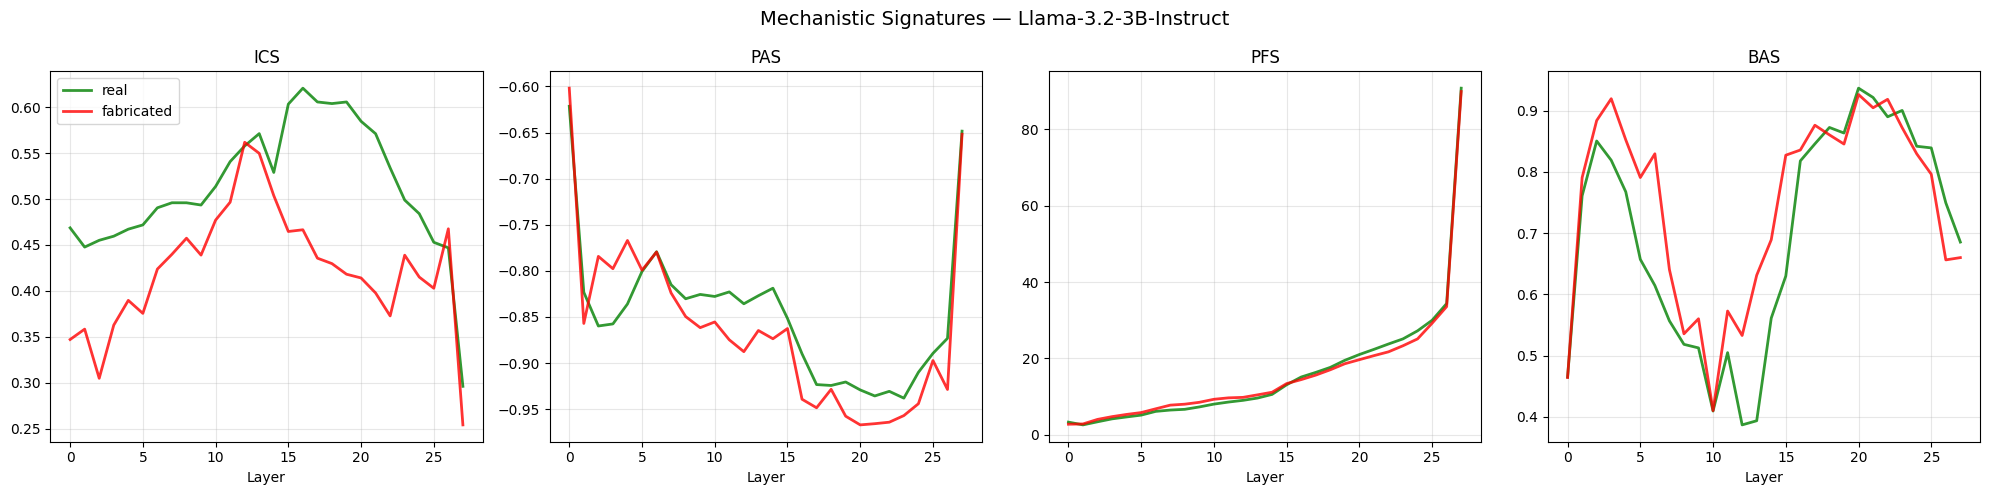

Saved to results/


In [ ]:
# --- RESULTS & VISUALIZATION ---
import pandas as pd
import matplotlib.pyplot as plt
import os, json

if all_scores:
    df = pd.DataFrame(all_scores)
    cols = [c for c in ["prompt_id","citation","label","ics_mean","pas_mean","pfs_mean","bas_mean"] if c in df.columns]
    display(df[cols].round(4))

    print("\n=== Averages by Label ===")
    num = [c for c in ["ics_mean","pas_mean","pfs_mean","bas_mean"] if c in df.columns]
    print(df.groupby("label")[num].mean().round(4).to_string())

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    metrics = [("ics_scores","ICS"), ("pas_scores","PAS"), ("pfs_scores","PFS"), ("bas_scores","BAS")]

    for ax, (key, title) in zip(axes, metrics):
        for label in df["label"].unique():
            if label == "unverified": continue
            sub = df[df["label"]==label]
            means = []
            for l in range(NUM_LAYERS):
                vals = [s[l] for s in sub[key] if len(s)>l]
                means.append(sum(vals)/len(vals) if vals else 0)

            color = "green" if label=="real" else ("red" if label=="fabricated" else "gray")
            ax.plot(range(NUM_LAYERS), means, label=label, color=color, alpha=0.8, linewidth=2)

        ax.set_title(title)
        ax.set_xlabel("Layer")
        if ax == axes[0]: ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"Mechanistic Signatures — {MODEL_NAME.split('/')[-1]}", fontsize=14)
    plt.tight_layout()
    plt.show()

os.makedirs("results", exist_ok=True)
with open("results/essays.json","w") as f: json.dump(essays, f, indent=2)
scores_out = [{k: ([float(x) for x in v] if isinstance(v,list) else v) for k,v in s.items()} for s in all_scores]
with open("results/scores.json","w") as f: json.dump(scores_out, f, indent=2)
print("Saved to results/")

old code

Reloading meta-llama/Llama-3.2-3B-Instruct for Original Method (POS)...


Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

Scoring with Original Method...


Scoring (Original): 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]

  Error sci_005: CUDA out of memory. Tried to allocate 1.29 GiB. GPU 0 has a total capacity of 14.56 GiB of which 1.06 GiB is free. Including non-PyTorch memory, this process has 13.50 GiB memory in use. Of the allocated memory 13.30 GiB is allocated by PyTorch, and 79.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

=== ORIGINAL METHOD RESULTS (Top 5) ===


,prompt_id,citation,label,ics_mean,pos_mean,pfs_mean,bas_mean
0,sci_001,"(Bates & Zaremba, 2016)",unverified,0.4869,0.1701,4.4276,0.6814
1,sci_001,Vaswani et al. (2017),unverified,0.3615,0.1434,3.9684,0.8277
2,sci_001,"Vaswani et al., 2017",unverified,0.4807,0.1665,4.2475,0.7544
3,sci_001,"Vaswani et al., 2017",unverified,0.5016,0.1713,4.3051,0.7083
4,sci_001,"Vaswani et al., 2017",unverified,0.5158,0.1635,4.2176,0.6790



=== Averages by Label (Original Method) ===
            ics_mean  pos_mean  pfs_mean  bas_mean
label                                             
fabricated    0.4607    0.1417    3.8418    0.7469
real          0.5146    0.1645    4.2209    0.7067
unverified    0.4937    0.1547    4.0541    0.7176


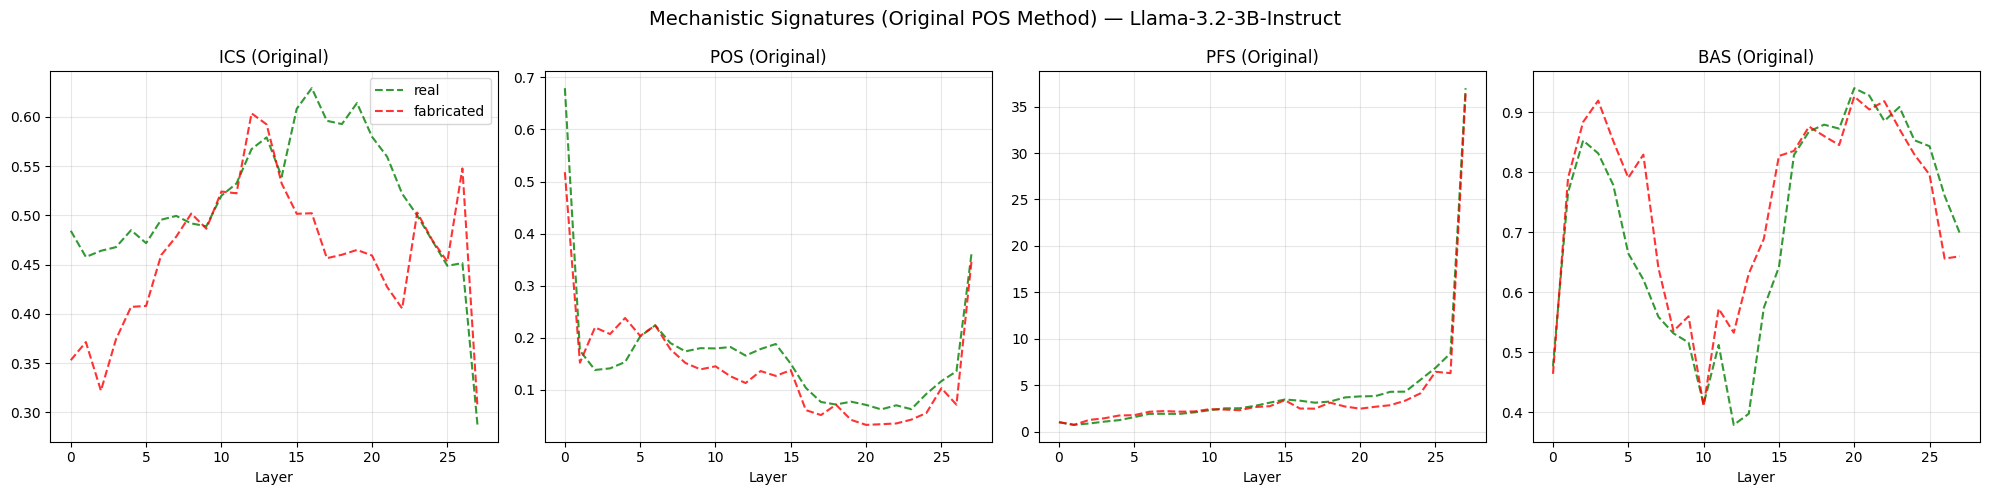

Saved to results/scores_original.json


In [ ]:
# === RUNNING FRIEND'S ORIGINAL METHOD (POS PROXY) ===
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import os, json
from tqdm import tqdm
from transformers import AutoModelForCausalLM

# 1. CLEAN START: Reload model to remove previous hooks
if 'scorer_model' in globals(): del scorer_model
torch.cuda.empty_cache()

print(f"Reloading {MODEL_NAME} for Original Method (POS)...")
scorer_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, device_map="auto",
    attn_implementation="eager",
)
scorer_model.eval()
NUM_LAYERS = scorer_model.config.num_hidden_layers

# 2. DEFINE ORIGINAL SCORING FUNCTION (POS Logic)
def score_citation_original(input_ids, tok_pos, essay_start, hidden_states, attn_weights):
    ics_scores, pos_scores, pfs_scores, bas_scores = [], [], [], []
    for layer in range(NUM_LAYERS):
        hs = hidden_states[layer + 1][0].cuda()

        # ICS (Original: No content mask, standard averaging)
        if layer < attn_weights.shape[0]:
            attn = attn_weights[layer, :, tok_pos, essay_start:tok_pos]
            if attn.shape[-1] > 0:
                attn_n = attn / (attn.sum(dim=-1, keepdim=True) + 1e-9)
                essay_repr = torch.matmul(attn_n.cuda(), hs[essay_start:tok_pos])
                ics = F.cosine_similarity(essay_repr, hs[tok_pos].unsqueeze(0), dim=-1).mean().item()
            else: ics = 0.0
        else: ics = 0.0
        ics_scores.append(ics)

        # POS (Original: 1 - abs(cos) of total layer change)
        pre = hidden_states[layer][0, tok_pos].cuda()
        post = hidden_states[layer + 1][0, tok_pos].cuda()
        cos = F.cosine_similarity(pre.unsqueeze(0), post.unsqueeze(0)).item()
        pos_scores.append(1.0 - abs(cos))

        # PFS (Standard)
        pfs_scores.append(torch.norm(post - pre).item() / 2)

        # BAS (Standard)
        bas = attn_weights[layer, :, tok_pos, 0].mean().item() if layer < attn_weights.shape[0] else 0.0
        bas_scores.append(bas)
        hs = hs.cpu()

    return {
        "ics_scores": ics_scores, "ics_mean": sum(ics_scores)/len(ics_scores),
        "pos_scores": pos_scores, "pos_mean": sum(pos_scores)/len(pos_scores),
        "pfs_scores": pfs_scores, "pfs_mean": sum(pfs_scores)/len(pfs_scores),
        "bas_scores": bas_scores, "bas_mean": sum(bas_scores)/len(bas_scores),
    }

# 3. EXECUTE SCORING LOOP
original_scores = []
print("Scoring with Original Method...")

for essay in tqdm(essays, desc="Scoring (Original)"):
    if not essay["citations"]: continue
    full_text = essay["prompt"] + essay["response"]
    enc = tokenizer(full_text, return_tensors="pt", return_offsets_mapping=True, truncation=True, max_length=4096)
    offsets = enc.offset_mapping[0].tolist()
    prompt_len = len(tokenizer(essay["prompt"], return_tensors="pt").input_ids[0])

    try:
        with torch.no_grad():
            out = scorer_model(
                input_ids=enc.input_ids.cuda(),
                output_hidden_states=True, output_attentions=True, return_dict=True,
            )
            hs = tuple(h.cpu() for h in out.hidden_states)
            attn = torch.stack(out.attentions).squeeze(1).cpu()
    except Exception as e:
        print(f"  Error {essay['prompt_id']}: {e}")
        continue

    for cite in essay["citations"]:
        char_start = cite["start_pos"] + len(essay["prompt"])
        tok_pos = None
        for i, (ts, te) in enumerate(offsets):
            if ts <= char_start < te:
                tok_pos = i; break
        if tok_pos is None or tok_pos >= enc.input_ids.shape[1]: continue

        scores = score_citation_original(enc.input_ids, tok_pos, prompt_len, hs, attn)
        scores.update({
            "prompt_id": essay["prompt_id"],
            "label": cite.get("label","unverified"),
            "citation": cite["raw_text"],
            "method": "original_pos"
        })
        original_scores.append(scores)

    del hs, attn, out; torch.cuda.empty_cache()

# 4. RESULTS & VISUALIZATION
if original_scores:
    df_orig = pd.DataFrame(original_scores)
    cols = [c for c in ["prompt_id","citation","label","ics_mean","pos_mean","pfs_mean","bas_mean"] if c in df_orig.columns]
    print("\n=== ORIGINAL METHOD RESULTS (Top 5) ===")
    display(df_orig[cols].head().round(4))

    print("\n=== Averages by Label (Original Method) ===")
    num = [c for c in ["ics_mean","pos_mean","pfs_mean","bas_mean"] if c in df_orig.columns]
    print(df_orig.groupby("label")[num].mean().round(4).to_string())

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    metrics = [("ics_scores","ICS"), ("pos_scores","POS"), ("pfs_scores","PFS"), ("bas_scores","BAS")]

    for ax, (key, title) in zip(axes, metrics):
        for label in df_orig["label"].unique():
            if label == "unverified": continue
            sub = df_orig[df_orig["label"]==label]
            means = []
            for l in range(NUM_LAYERS):
                vals = [s[l] for s in sub[key] if len(s)>l]
                means.append(sum(vals)/len(vals) if vals else 0)

            color = "green" if label=="real" else ("red" if label=="fabricated" else "gray")
            ax.plot(range(NUM_LAYERS), means, label=label, color=color, alpha=0.8, linestyle="--")

        ax.set_title(f"{title} (Original)")
        ax.set_xlabel("Layer")
        if ax == axes[0]: ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"Mechanistic Signatures (Original POS Method) — {MODEL_NAME.split('/')[-1]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# 5. SAVE SEPARATELY
os.makedirs("results", exist_ok=True)
scores_out = [{k: ([float(x) for x in v] if isinstance(v,list) else v) for k,v in s.items()} for s in original_scores]
with open("results/scores_original.json","w") as f: json.dump(scores_out, f, indent=2)
print("Saved to results/scores_original.json")